In [15]:
import random
from collections import defaultdict, namedtuple
from enum import Enum
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import bernoulli

import numpy as np
from itertools import product


class Action(Enum):
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3

width = 10
height = 10


class MDP:
    def __init__(self, lion_pos=(height - 1, 0), cow_positions=([(0, width - 1)])):
        self.lion_i, self.lion_j = lion_pos
        self.cow_positions = cow_positions

        self.START_STATE = (self.lion_i, self.lion_j, tuple(False for _ in cow_positions))
        self.END_STATE = (self.lion_i, self.lion_j, tuple(True for _ in cow_positions))
        
        self.states = self._get_states()
        self.actions = self._get_actions()
        self.transitions = {(s, a): self._move(s, a) for s in self.states for a in self.actions[s]}
        self.reward = self._get_reward()

    def _cows_vec(s):
        return s[2]
       
    def _valid_state(self, s):
        return s[0] in range(0, height) and s[1] in range(0, width)

    def _try_move(self, s, a):
        next_s = None
        if a == Action.UP:
            next_s = (s[0] - 1, s[1], s[2])
        elif a == Action.DOWN:
            next_s = (s[0] + 1, s[1], s[2])
        elif a == Action.LEFT:
            next_s = (s[0], s[1] - 1, s[2])
        elif a == Action.RIGHT:
            next_s = (s[0], s[1] + 1, s[2])
        return next_s
        
    def _move(self, cell, direction):
        next_cell = self._try_move(cell, direction)
        
        if not self._valid_state(next_cell):
            return cell
        
        if (next_cell[0], next_cell[1]) in self.cow_positions:
            cow_ind = self.cow_positions.index((next_cell[0], next_cell[1]))
            new_cow_vec = tuple(True if i == cow_ind else e for i, e in enumerate(cell[2]))
            next_cell = (next_cell[0], next_cell[1], new_cow_vec)

        return next_cell

    def _get_actions(self):
        actions = {}
        for s in self.states:
            actions[s] = []
            if s[0] > 0:
                actions[s].append(Action.UP)
            if s[0] < height - 1:
                actions[s].append(Action.DOWN)
            if s[1] > 0:
                actions[s].append(Action.LEFT)
            if s[1] < width -1:
                actions[s].append(Action.RIGHT)
                
        return actions

    def _get_reward(self):
        reward_partial = {}

        for s in self.states:
            for a in self.actions[s]:
                next_state = self.transitions[(s, a)]
                if next_state == self.END_STATE:
                    reward_partial[(s, a)] = 100
                if (next_state[0], next_state[1]) in self.cow_positions:
                    cow_ind = self.cow_positions.index((next_state[0], next_state[1]))
                    if not s[2][cow_ind]:
                        reward_partial[(s, a)] = 50

        return defaultdict(int, reward_partial)

    def _get_states(self):
        states = []
        for i in range(height):
            for j in range(width):
                ncows = len(self.cow_positions)
                if (i, j) in self.cow_positions:
                    indx = self.cow_positions.index((i, j))
                    cvs = tuple(prod for prod in product([False, True], repeat=ncows) if prod[indx])
                else:
                    cvs = tuple(product([False, True], repeat=ncows))
                    
                for cw in cvs:
                    states.append((i, j, cw))

        return states

In [2]:
def get_policy(mdp, Q, eps=0.3):
    policy = {}
    for s in mdp.states:
        i = np.argmax([Q[(s, a)] for a in mdp.actions[s]])
        ba = mdp.actions[s][i]
        for a in mdp.actions[s]:
            if a == ba:
                policy[(s, a)] = 1 - eps + eps / len(mdp.actions[s]) 
            else:
                policy[(s, a)] = eps / len(mdp.actions[s])
    return policy

In [63]:
def get_action(mdp, policy, s):
    prob = random.uniform(0, 1)
    for a in mdp.actions[s]:
        if prob <= policy[(s, a)]:
            return a
        prob -= policy[(s, a)]
    raise ValueError("Policy probabilities should sum up to 1")

#     eps = 0.3
#     choose_opt = (bernoulli.rvs(1 - eps) == 1)
#     if choose_opt:
#         i = np.argmax([policy[(s, a)] for a in mdp.actions[s]])
#         return mdp.actions[s][i]
#     else:
#         As = mdp.actions[s]
#         return As[np.random.random_integers(0, len(As) - 1)]

In [25]:
def sarsa(mdp, n_episodes, alpha, gamma, eps=0.3):
    timestampes = []
    nepisodes = []

    Q = {}
    for s in mdp.states:
        for a in mdp.actions[s]:
            Q[(s, a)] = 1

    policy = get_policy(mdp, Q)
            
    time_cnt = 0
    epi_cnt = 0
    for _ in range(n_episodes):
        s = mdp.START_STATE
        a = random.choice(mdp.actions[s])
        while s != mdp.END_STATE:
            r = mdp.reward[(s, a)]
            ss = mdp.transitions[(s, a)]
            aa = get_action(mdp, policy, ss)
            
            Q[(s, a)] += alpha * (r + gamma * Q[(ss, aa)] - Q[(s, a)])
            
            i = np.argmax([Q[(s, a_i)] for a_i in mdp.actions[s]])
            ba = mdp.actions[s][i]
            for a in mdp.actions[s]:
                if a == ba:
                    policy[(s, a)] = 1 - eps + eps / len(mdp.actions[s]) 
                else:
                    policy[(s, a)] = eps / len(mdp.actions[s])

            s = ss
            a = aa
            timestampes.append(time_cnt)
            nepisodes.append(epi_cnt)

            time_cnt += 1
        epi_cnt += 1
    return get_policy(mdp, Q), timestampes, nepisodes

In [32]:
def Q_learning(mdp, n_episodes, alpha, gamma, eps=0.3):
    timestampes = []
    nepisodes = []

    Q = {}
    for s in mdp.states:
        for a in mdp.actions[s]:
            Q[(s, a)] = 1

    policy = get_policy(mdp, Q)
            
    time_cnt = 0
    epi_cnt = 0
    for _ in range(n_episodes):
        s = mdp.START_STATE
        
        while s != mdp.END_STATE:
            a = get_action(mdp, policy, s)
            r = mdp.reward[(s, a)]
            ss = mdp.transitions[(s, a)]
            
            Q[(s, a)] += alpha * (r + gamma * np.max([Q[(ss, aa)] for aa in mdp.actions[ss]]) - Q[(s, a)])
            
            i = np.argmax([Q[(s, a_i)] for a_i in mdp.actions[s]])
            ba = mdp.actions[s][i]
            for a in mdp.actions[s]:
                if a == ba:
                    policy[(s, a)] = 1 - eps + eps / len(mdp.actions[s]) 
                else:
                    policy[(s, a)] = eps / len(mdp.actions[s])

            s = ss
            
            timestampes.append(time_cnt)
            nepisodes.append(epi_cnt)

            time_cnt += 1
        epi_cnt += 1
    return get_policy(mdp, Q), timestampes, nepisodes

In [16]:
random.seed(42)
mdp = MDP()

In [56]:
def plot_sarsa(mdp):
    policy, timestampes, nepisodes = sarsa(mdp, n_episodes=50, alpha=0.5, gamma=0.5)

    plt.plot(timestampes, nepisodes)
    plt.xlabel('Time steps')
    plt.ylabel('Episodes')
    plt.title('Results of SARSA')
    plt.show()

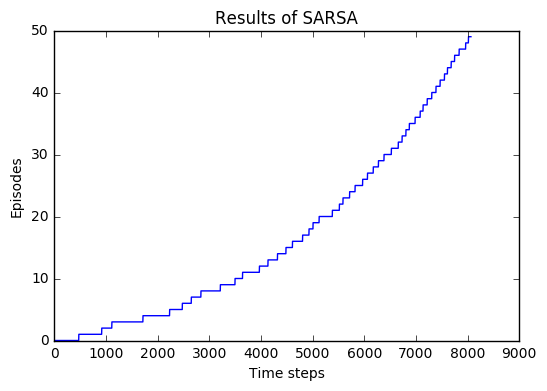

In [77]:
plot_sarsa(mdp)

In [53]:
def plot_Ql(mdp):
    policy, timestampes, nepisodes = Q_learning(mdp, n_episodes=50, alpha=0.5, gamma=0.5)

    plt.plot(timestampes, nepisodes)
    plt.xlabel('Time steps')
    plt.ylabel('Episodes')
    plt.title('Results of Q learning')
    plt.show()

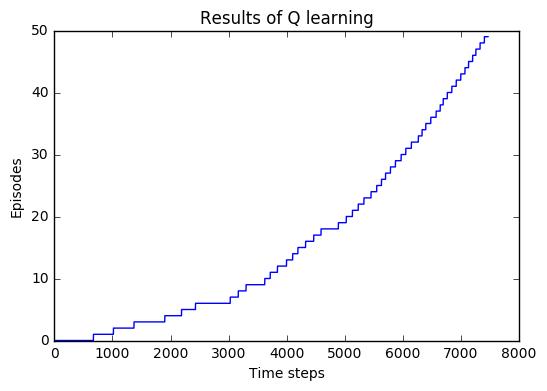

In [76]:
plot_Ql(mdp)

In [27]:
def generate_episode(mdp, policy):
    episode = []
    reward = 0
    rewards = []

    s = mdp.START_STATE
    a = random.choice(mdp.actions[s])

    while s != mdp.END_STATE:
        episode.append((s, a))
        r = mdp.reward[(s, a)]
        rewards.append(r)
        ss = mdp.transitions[(s, a)]
        aa = get_action(mdp, policy, ss)
        s = ss
        a = aa
        reward += r

    rewards_cumsum = np.cumsum(rewards[::-1])[::-1]
    reward_after = {}
    for (s, a), r in reversed(list(zip(episode, rewards_cumsum))):
        if (s, a) not in reward_after:
            reward_after[(s, a)] = r

    return episode, reward, defaultdict(int, reward_after)

In [65]:
def on_policy_first_visit_mc_control(mdp, eps, n_episodes):
    timestampes = []
    nepisodes = []

    Q = {}
    R = {}
    policy = {}
    for s in mdp.states:
        for a in mdp.actions[s]:
            Q[(s, a)] = 0
            R[(s, a)] = []
            policy[(s, a)] = 1 / len(mdp.actions[s])

    time_cnt = 0
    epi_cnt = 0
    while epi_cnt < n_episodes:
        episode, reward, reward_after = generate_episode(mdp, policy)

        for _ in episode:
            nepisodes.append(epi_cnt)
            timestampes.append(time_cnt)
            time_cnt += 1
        epi_cnt += 1

        episode_unique = list(set(episode))
        for s, a in episode_unique:
            R[(s, a)].append(reward_after[(s, a)])
            Q[(s, a)] = np.mean(R[(s, a)])
        epi_states = [s for s, _ in episode_unique]

        for s in epi_states:
            i = np.argmax([Q[(s, a)] for a in mdp.actions[s]])
            ba = mdp.actions[s][i]
            for a in mdp.actions[s]:
                if a == ba:
                    policy[(s, a)] = 1 - eps + eps / len(mdp.actions[s])
                else:
                    policy[(s, a)] = eps / len(mdp.actions[s])

        epi_cnt += 1
        
    return policy, timestampes, nepisodes

In [74]:
def plot_mc(mdp):
    policy, timestampes, nepisodes = on_policy_first_visit_mc_control(mdp, eps=0.9, n_episodes=50)

    plt.plot(timestampes, nepisodes)
    plt.xlabel('Time steps')
    plt.ylabel('Episodes')
    plt.title('Results of MC')
    plt.show()

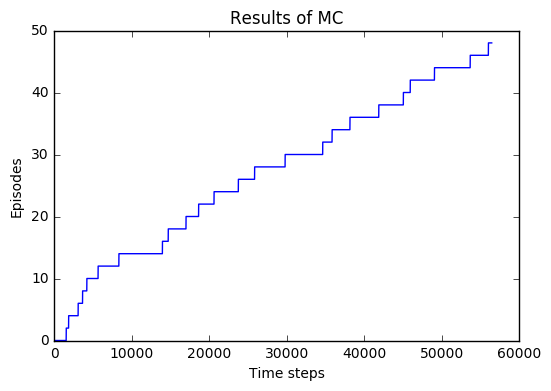

In [75]:
plot_mc(mdp)

In [49]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def initalize_policy(mdp):
    values = {}
    policy = {}
    policy_prob = {}
    for s in mdp.states:
        values[s] = 1
        policy[s] = random.choice(mdp.actions[s])
        for a in mdp.actions[s]: 
            policy_prob[(s, a)] = 1. / len(mdp.actions[s])
    return values, policy, policy_prob

def policy_evaluation(mdp, values, policy_prob, gamma, theta, eval_iter):
    while True:
        eval_iter += 1
        delta = 0
        for s in mdp.states:
            v = values[s]
            values[s] = sum([policy_prob[(s, a)] * (r + gamma * values[ss]) 
                             for a in mdp.actions[s] 
                             for ss in [mdp.transitions[(s, a)]] 
                             for r in [mdp.reward[(s, a)]]])
            delta = max(delta, abs(v - values[s]))
        if delta < theta:
            return eval_iter, values
        
def policy_iteration(mdp, theta, gamma):
    values, policy, policy_prob = initalize_policy(mdp)
    
    improv_iter = 0
    eval_iter = 0
    policy_stable = False
    while not policy_stable:
        eval_iter, values = policy_evaluation(mdp, values, policy_prob, gamma, theta, eval_iter)
        
        improv_iter += 1
        policy_stable = True
        for s in mdp.states:
            old_action = policy[s]
            candidates = [r + gamma * values[ss] for a in mdp.actions[s] 
                          for ss in [mdp.transitions[(s, a)]] for r in [mdp.reward[(s, a)]]]
            maxi = np.argmax(candidates)
            policy[s] = mdp.actions[s][maxi]
                    
            for i, a in enumerate(mdp.actions[s]):
                sm = softmax(candidates)
                policy_prob[(s, a)] = sm[i]
            
            if old_action != policy[s]:
                policy_stable = False
            
    print("Evaluations iterations", eval_iter)
    print("Improvement iterations:", improv_iter)
    return values, policy

def plot_policy(policy_vals):
    skeys = sorted(policy_vals.keys())
    x = np.array([a for a, _ in skeys])
    y = np.array([b for _, b in skeys])

    temp = np.array([policy_vals[k] for k in skeys])

    nrows, ncols = height, width
    grid = temp.reshape((nrows, ncols))

    plt.imshow(grid, extent=(x.min(), x.max(), y.max(), y.min()), cmap="hot")
    plt.show()

Evaluations iterations 169
Improvement iterations: 45


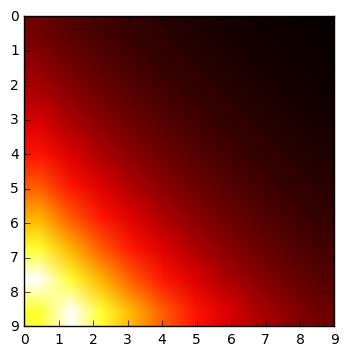

In [50]:
policy_vals, _ = policy_iteration(mdp, theta=0.001, gamma=0.8)
policy = {(state[0], state[1]): policy_vals[state] for state in policy_vals if state[2][0]}
plot_policy(policy)

In [52]:
mdp2 = MDP(cow_positions=[(height - 1,width - 1), (0, width - 1)])

/home/austud/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: DeprecationWarning: This function is deprecated. Please call randint(0, 3 + 1) instead
/home/austud/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: DeprecationWarning: This function is deprecated. Please call randint(0, 2 + 1) instead
/home/austud/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead


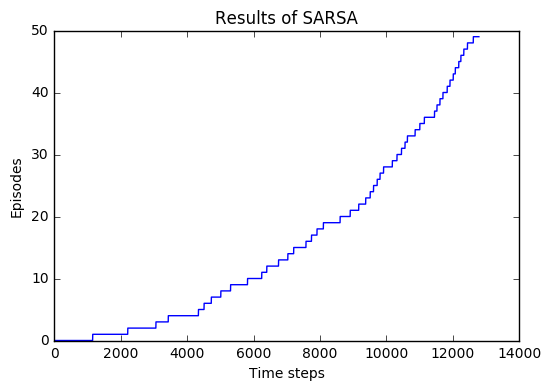

In [58]:
plot_sarsa(mdp2)

/home/austud/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: DeprecationWarning: This function is deprecated. Please call randint(0, 2 + 1) instead
/home/austud/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: DeprecationWarning: This function is deprecated. Please call randint(0, 3 + 1) instead
/home/austud/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead


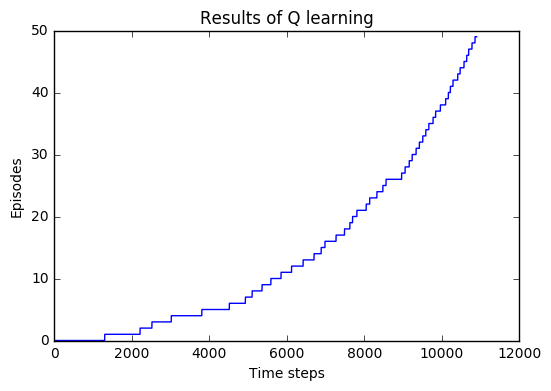

In [55]:
plot_Ql(mdp2)

Evaluations iterations 195
Improvement iterations: 58


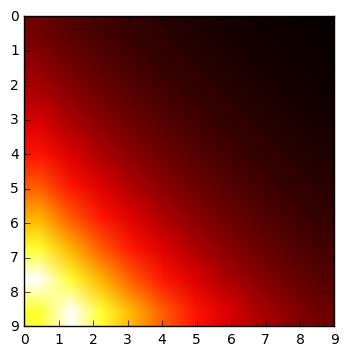

In [60]:
policy_vals, _ = policy_iteration(mdp2, theta=0.001, gamma=0.8)
policy = {(state[0], state[1]): policy_vals[state] for state in policy_vals if state[2] == (True, True)}
plot_policy(policy)